In [22]:
import numpy as np
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# Load simulation data
b_sim = bagreader('2023-04-19-10-50-24.bag')

ODOM_SIM = b_sim.message_by_topic('/rr_robot/odom')
SCAN_SIM = b_sim.message_by_topic('/scan')
VEL_SIM = b_sim.message_by_topic('/velX')
YAW_SIM = b_sim.message_by_topic('/yaw')

df_odom = pd.read_csv(ODOM_SIM)
df_scan = pd.read_csv(SCAN_SIM)
df_vel = pd.read_csv(VEL_SIM)
df_yaw = pd.read_csv(YAW_SIM)

[INFO]  Data folder 2023-04-19-10-50-24 already exists. Not creating.


In [24]:
df_scan

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,angle_min,angle_max,angle_increment,time_increment,scan_time,...,ranges_90,ranges_91,ranges_92,ranges_93,ranges_94,ranges_95,ranges_96,ranges_97,ranges_98,ranges_99
0,12.067,4202,12,64000000,dummy,-1.57,1.57,0.0314,0.00025,0.0,...,1.021659,1.014126,1.007690,1.002316,0.997979,0.994655,0.992328,0.990987,0.990625,0.991240
1,12.067,4203,12,65000000,dummy,-1.57,1.57,0.0314,0.00025,0.0,...,1.021648,1.014116,1.007681,1.002309,0.997972,0.994649,0.992323,0.990983,0.990621,0.991237
2,12.068,4204,12,66000000,dummy,-1.57,1.57,0.0314,0.00025,0.0,...,1.021636,1.014106,1.007671,1.002300,0.997964,0.994641,0.992316,0.990977,0.990616,0.991233
3,12.068,4205,12,67000000,dummy,-1.57,1.57,0.0314,0.00025,0.0,...,1.021626,1.014096,1.007662,1.002292,0.997957,0.994635,0.992311,0.990972,0.990613,0.991230
4,12.068,4206,12,68000000,dummy,-1.57,1.57,0.0314,0.00025,0.0,...,1.021614,1.014085,1.007652,1.002283,0.997948,0.994628,0.992305,0.990967,0.990608,0.991226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29999,42.063,34201,42,63000000,dummy,-1.57,1.57,0.0314,0.00025,0.0,...,0.835018,0.832410,0.830634,0.829682,0.829550,0.830235,0.831743,0.834079,0.837257,0.841292
30000,42.064,34202,42,64000000,dummy,-1.57,1.57,0.0314,0.00025,0.0,...,0.835009,0.832400,0.830624,0.829671,0.829538,0.830223,0.831730,0.834066,0.837243,0.841277
30001,42.065,34203,42,65000000,dummy,-1.57,1.57,0.0314,0.00025,0.0,...,0.835000,0.832391,0.830614,0.829661,0.829527,0.830212,0.831719,0.834054,0.837231,0.841264
30002,42.066,34204,42,66000000,dummy,-1.57,1.57,0.0314,0.00025,0.0,...,0.834990,0.832381,0.830603,0.829650,0.829516,0.830200,0.831706,0.834041,0.837217,0.841249


In [25]:
# Check minimum distance as observed by the fake laser
df_ranges = df_scan.drop(df_scan.iloc[:, 1:12],axis = 1)
df_le_dist = df_scan.drop(df_scan.iloc[:, 1:],axis = 1)
ranges_min = df_ranges.min(axis=1)
df_le_dist['ranges_min'] = ranges_min
df_le_dist

,Time,ranges_min
0,12.067,0.990625
1,12.067,0.990621
2,12.068,0.990616
3,12.068,0.990613
4,12.068,0.990608
...,...,...
29999,42.063,0.829550
30000,42.064,0.829538
30001,42.065,0.829527
30002,42.066,0.829516


In [26]:
# Check velocity
df_vel.describe()

,Time,data
count,30004.000000,30004.000000
mean,27.065522,0.049617
std,8.661651,0.002415
min,12.067000,0.045550
25%,19.564750,0.048142
50%,27.065500,0.048685
75%,34.566250,0.051268
max,42.067000,0.056312


In [27]:
# Check yaw
df_yaw.describe()

,Time,data
count,30004.000000,30004.000000
mean,27.065472,0.105485
std,8.661646,0.077124
min,12.067000,-0.042407
25%,19.564500,0.046898
50%,27.065500,0.122733
75%,34.566250,0.172729
max,42.067000,0.209068


In [28]:
# Traveled distance
dx_sim =df_odom['pose.pose.position.x'][df_odom.index[-1]] - df_odom['pose.pose.position.x'][df_odom.index[0]]
dy_sim =df_odom['pose.pose.position.y'][df_odom.index[-1]] - df_odom['pose.pose.position.y'][df_odom.index[0]]

In [29]:
df_vel

,Time,data
0,12.067,0.051969
1,12.067,0.051969
2,12.067,0.051969
3,12.067,0.051969
4,12.068,0.051969
...,...,...
29999,42.063,0.055604
30000,42.064,0.055604
30001,42.065,0.055604
30002,42.065,0.055604


<AxesSubplot:xlabel='Time', ylabel='Velocity X (m/s)'>

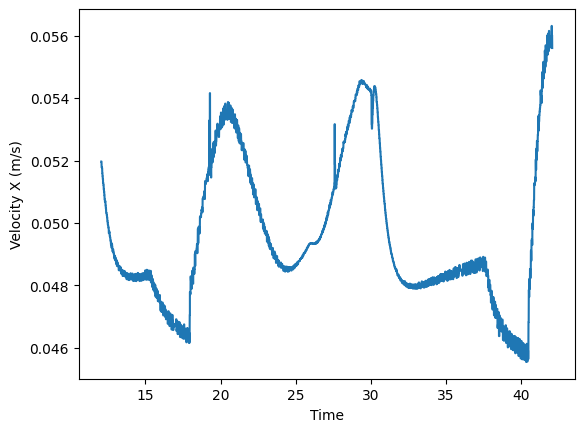

In [30]:
# Plot velocity
df_vel.plot(x='Time', y='data', ylabel='Velocity X (m/s)', legend=False)

<AxesSubplot:xlabel='Time', ylabel='Yaw (rad)'>

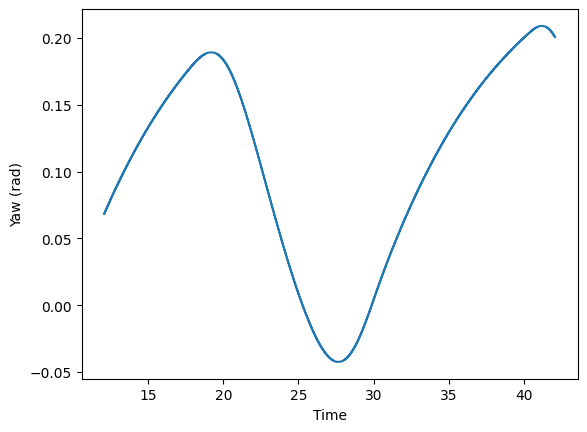

In [31]:
# Plot yaw
df_yaw.plot(x='Time', y='data', ylabel='Yaw (rad)', legend=False)

<AxesSubplot:xlabel='Time', ylabel='LE distance (m)'>

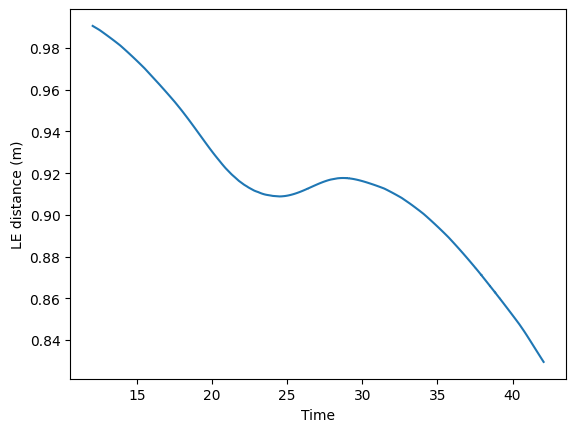

In [32]:
# Plot LE distance
df_le_dist.plot(x='Time', y='ranges_min', ylabel='LE distance (m)', legend=False)

<AxesSubplot:xlabel='Time', ylabel='X-position (m)'>

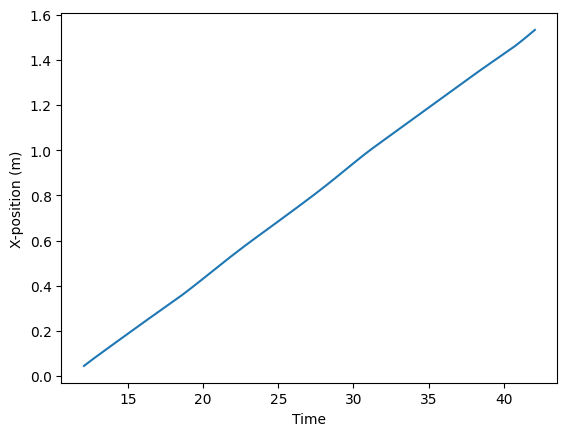

In [33]:
# Plot position
df_odom.plot(x='Time', y='pose.pose.position.x', ylabel='X-position (m)', legend=False)

<AxesSubplot:xlabel='Time', ylabel='Y-position (m)'>

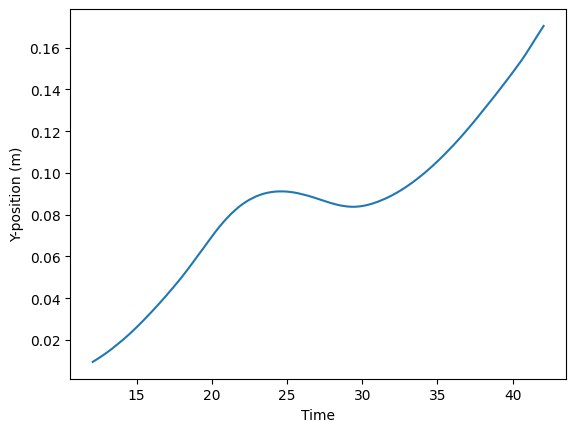

In [34]:
# Plot position
df_odom.plot(x='Time', y='pose.pose.position.y', ylabel='Y-position (m)', legend=False)